In [17]:
# Utils imports
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

# Dataframe loadings imports
import bz2
import json
import os
import joblib
import dask.dataframe as dd

# Models imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# News Data Collection & Pre-Processing

Unfortunately, we were not able to find a dataset of a satisfying size with news related to our sector. Therefore, we first collected news data from different sources, then filtered the artciles of interest based on a pre-defined vocabulary.

In [2]:
# vocabulary to filter the sector of interest
agriculture_keywords = [

    # --- General Agriculture Terms ---
    "agriculture", "agronomy", "agribusiness", "farming", "cultivation",
    "horticulture", "irrigation", "harvesting", "tillage", "soil",
    "sustainable agriculture", "organic farming", "monoculture", "crop rotation",

    # --- Crops ---
    "crop", "corn", "maize", "rice", "wheat", "soybean",
    "oats", "cotton", "sugarcane", "tobacco", "legumes", "vegetables", "fruits",

    # --- Inputs & Equipment ---
    "seed", "compost", "manure", "fertilizer", "pesticide", "machinery", "GPS farming",

    # --- Agriculture Markets & Policy ---
    "commodity", "commodity prices", "farm subsidy", "rural economy",
    "agricultural exports", "biofuel", "grain reserves",

    # --- Politics & Geopolitics ---
    "armed conflict", "political instability", "economic sanctions",
    "trade blockade", "embargo", "trade war", "diplomatic relations",
    "geopolitical crisis", "government collapse", "political transition",

    # --- War & Security ---
    "war zone", "military occupation", "supply chain disruption",
    "targeted attacks", "invasion", "rural exodus", "forced displacement",
    "landmines", "collateral damage", "war crimes",

    # --- Agricultural Impact & Food Systems ---
    "food crisis", "food security", "agri-food system", "crop yields",
    "food prices", "supply disruption", "import dependency",
    "damaged farmland", "fertilizer shortage", "labor shortage",
    "commodity shock", "agricultural subsidy",

    # --- Institutions & Policy Concepts ---
    "food and agriculture organization", "world bank",
    "world food programme", "system resilience", "land reforms",
    "agricultural policy"
]

def filter_agri(df, title, description):
    """function to obtain the rows related to agriculture
        args:
            - title: set to True if df has a "title" column
            - description : set to True if df has a "description" column
    """
    pattern = r"\b(" + "|".join(re.escape(word) for word in agriculture_keywords) + r")\b"

    if title and description:
        mask = (
            df["title"].str.contains(pattern, case=False, na=False) |
            df["description"].str.contains(pattern, case=False, na=False)
        )
    elif title:
        mask = (
            df["title"].str.contains(pattern, case=False, na=False) 
        )
    elif description:
        mask = (
            df["description"].str.contains(pattern, case=False, na=False)
        )
        
    df_filtered = df[mask].copy()
    return df_filtered

def time_analysis(df):
    """plots the distribution of articles within df over time"""

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    date_counts = df['date'] .dt.date.value_counts().sort_index() 

    plt.figure(figsize=(10, 6))
    date_counts.plot(kind='line')
    plt.xlabel('Publication Date')
    plt.ylabel('Count of Rows')
    plt.title('Distribution of Rows per Publication Date')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return df

## AG News Dataset 2004 - 2008

AG News is another collection of more than 1 million news articles gathered from more than 2'000 sources, from which we successfully retrieved 13'824 articles related to our sector, from August 2004 to February 2008. 

In [3]:
results = []
with bz2.open('data/newsSpace.bz2', 'rt', encoding='latin1') as f:
    count = 0
    for line in f:
        test = line.strip()
        results.append(test)

full_text = "\n".join(results)
documents = full_text.split(r"\N")

Initial dataset size : 1078255
Filtered dataset size : 13824


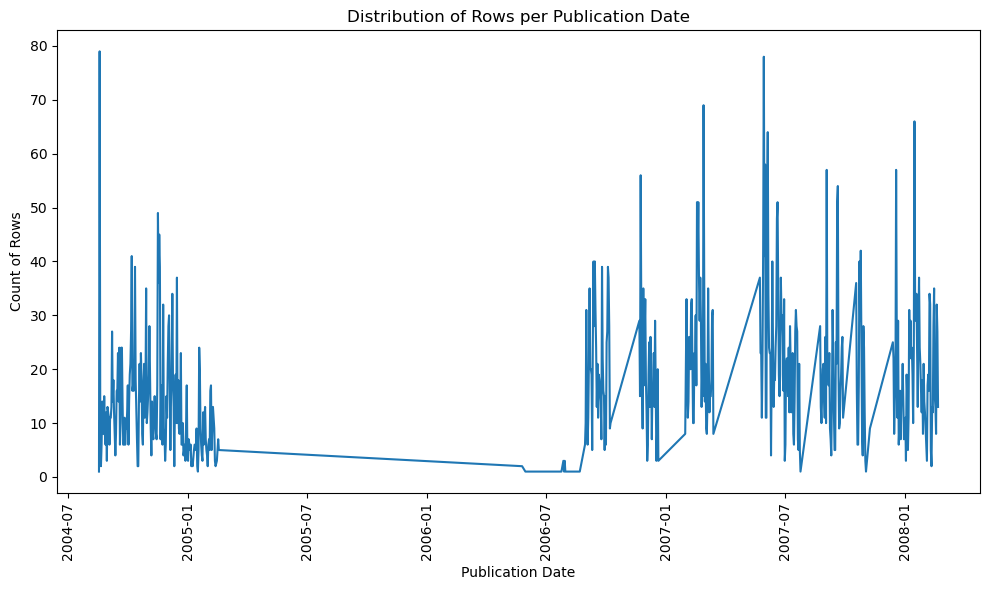

In [4]:
parsed_rows = []
for doc in documents:
    fields = doc.split('\t')
    if len(fields) == 9:
        parsed_rows.append(fields)
    elif len(fields) == 10 and fields[0]=="\nCNET\\":
        del fields[1]
        parsed_rows.append(fields)

ag_df = pd.DataFrame(parsed_rows, columns=[
    "source", "url", "title", "image", "category", "description", "rank", "pubdate", "video"
])

cols = ["title", "pubdate", "source", "url", "image", "category", "description", "rank", "video"]
ag_df = ag_df[cols]
print("Initial dataset size : " + str(len(ag_df)))

ag_df = ag_df[['title', 'description', 'pubdate', 'url', 'source']].rename(columns={'pubdate': 'date'})
ag_agri_df = filter_agri(ag_df, True, True)
print("Filtered dataset size : " + str(len(ag_agri_df)))

# Note that articles where the date was not retrievable were stored with 0000-00-00 00:00:00
ag_agri_df = time_analysis(ag_agri_df)

## AG News 2020-2021

AG News is a dataset of 17'484 news' articles gathered from other 2000 sources which has been classified by topic. It contains news from mid 2020 to late 2021. Each individual sample are arranged in folder corresponding to the date of publication.

To run this whole code, you would need to add the folder final_corpus to a "data" folder within the project. However, to not waiste time, just load the file christo_df.joblib to the "data" folder and do not run the first cell below.

In [5]:
# This code was used to download the AG News, however, as it is quite time/space expensive, we
# have stored the results of this cell to "christo_df.joblib".

#base_path = 'data/final_corpus'

#data_rows = []

#for root, dirs, files in os.walk(base_path):
    #for file in files:
        #if file.endswith('.json'):
            #file_path = os.path.join(root, file)
            #try:
                #with open(file_path, 'r', encoding='utf-8') as f:
                    #raw_json = json.load(f)

                #info = raw_json.get("OPEN_CALAIS", {}).get("doc", {}).get("info", {})

                #document = info.get("document", "")
                #doc_title = info.get("docTitle", "")
                #doc_date_str = info.get("docDate", "")
                #doc_date = pd.to_datetime(doc_date_str, errors='coerce')  # returns NaT if invalid

                #folder_date_str = os.path.basename(root)
                #folder_date = pd.to_datetime(folder_date_str, errors='coerce')

                #data_rows.append({
                    #"description": document,
                    #"title": doc_title,
                    #"date": folder_date,
                #})

            #except Exception as e:
                #print(f"Failed to process {file_path}: {e}")

#christo_df = pd.DataFrame(data_rows)

#print(f"Loaded {len(christo_df)} documents.")
#joblib.dump(christo_df, 'data/christo_df.joblib')

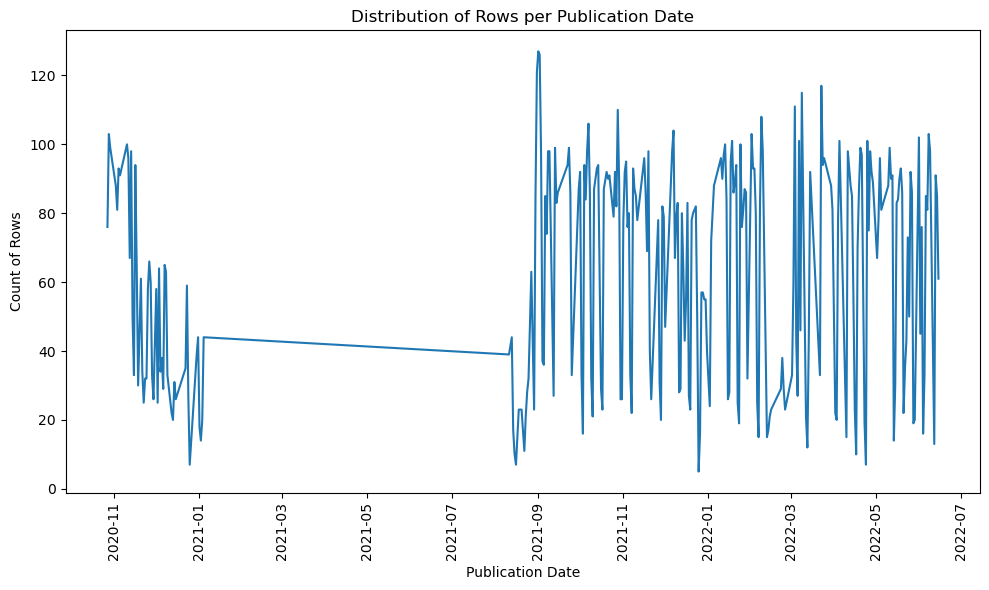

In [6]:
christo_df = joblib.load('data/christo_df.joblib')
christo_df = time_analysis(christo_df)

# re-order the df so that it matches the rest
christo_df = christo_df[['title', 'description', 'date']]

## Kaggle News Dataset

https://www.kaggle.com/datasets/rmisra/news-category-dataset : The News Category Dataset contains around 210k news headlines from 2012 to 2022 from $\textit{HuffPost}$. We successfully retrieved 1'537 agriculture-related articles for our work.

To run this code add the file "News_Category_Dataset_v3.json" to a folder "data" within the project.

Initial dataset size : 209527
Filtered dataset size : 1537


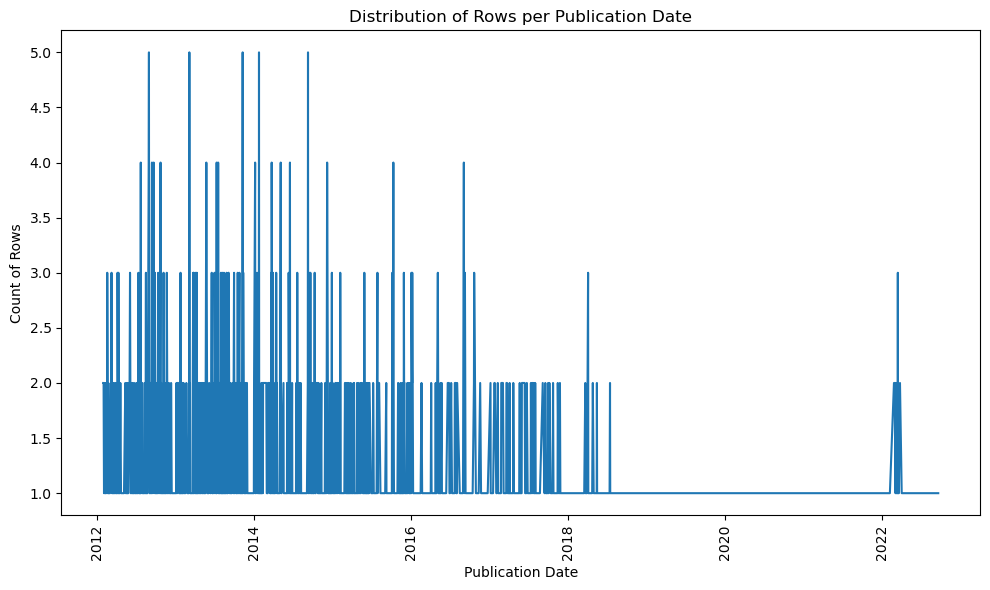

In [7]:
import pandas as pd

file_path = 'data/News_Category_Dataset_v3.json'
kaggle_df = pd.read_json(file_path, lines=True)
kaggle_df['date'] = pd.to_datetime(kaggle_df['date'], errors='coerce')

kaggle_df = kaggle_df[['headline', 'short_description', 'date', 'link']].rename(
    columns={'headline': 'title', 'short_description': 'description', 'link': 'url'}
)
kaggle_df['source'] = 'HuffPost'

print("Initial dataset size : " + str(len(kaggle_df)))

kaggle_df_agri = filter_agri(kaggle_df, True, True)
print("Filtered dataset size : " + str(len(kaggle_df_agri)))

kaggle_df_agri = time_analysis(kaggle_df_agri)

## Hugging Face Datasets

#### Financial News

Daily Financial News contains around 1,5 million news' articles related to over 2'000 different stocks, scraped from Benzinga. From this dataset, 11'982 articles were recognized as agriculture-related from 2010 to 2020.

https://huggingface.co/datasets/ashraq/financial-news 

Initial dataset size : 1845559
Filtered dataset size : 11982


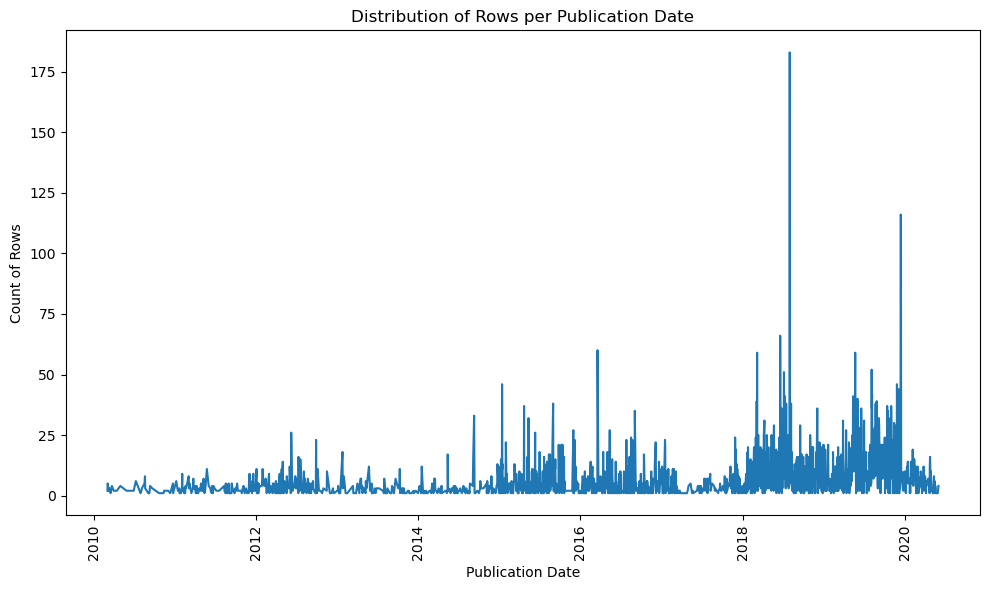

In [8]:
hf_fin_news_df = pd.read_parquet("hf://datasets/ashraq/financial-news/data")
hf_fin_news_df = hf_fin_news_df[['headline', 'date', 'url', 'publisher']].rename(
    columns={'headline': 'title', 'publisher': 'source'}
)

print("Initial dataset size : " + str(len(hf_fin_news_df)))

hf_fin_news_df_agri = filter_agri(hf_fin_news_df, True, False)
print("Filtered dataset size : " + str(len(hf_fin_news_df_agri)))

hf_fin_news_df_agri = time_analysis(hf_fin_news_df_agri)

#### BBC News All Time

This datasets contains all news articles from BBC News that were created every months from 2017 to current.

https://huggingface.co/datasets/RealTimeData/bbc_news_alltime

Initial dataset size : 1688
Filtered dataset size : 8


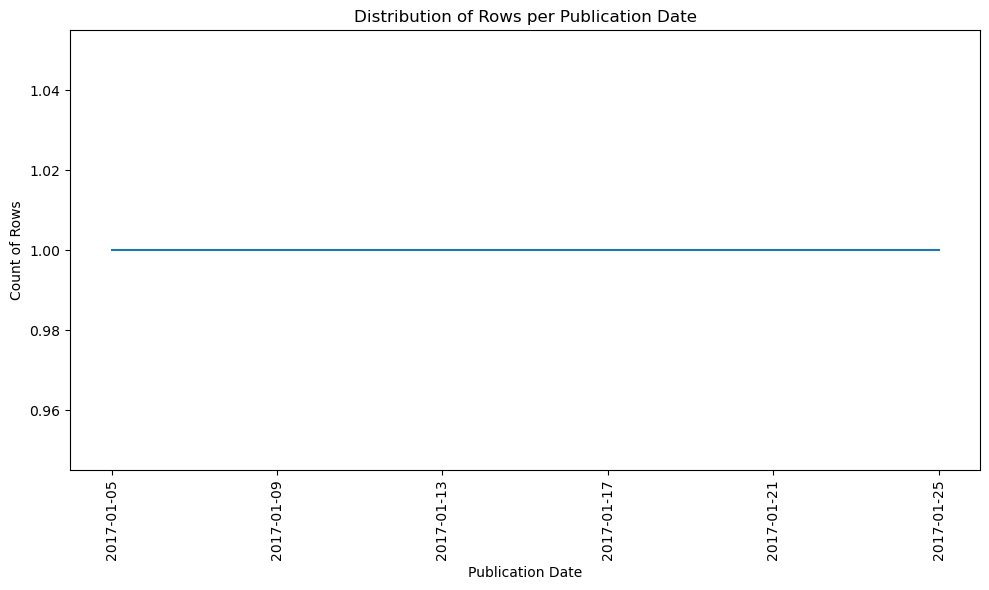

In [9]:
# https://huggingface.co/datasets/RealTimeData/bbc_news_alltime
hf_bbc_alltime_df = pd.read_parquet("hf://datasets/RealTimeData/bbc_news_alltime/2017-01/train-00000-of-00001-e60bfec9cae4b857.parquet")
hf_bbc_alltime_df = hf_bbc_alltime_df[['title', 'description', 'published_date', 'link']].rename(
    columns={'published_date': 'date', 'link': 'url'}
)
hf_bbc_alltime_df['source'] = 'BBC'

print("Initial dataset size : " + str(len(hf_bbc_alltime_df)))

hf_bbc_alltime_df_agri = filter_agri(hf_bbc_alltime_df, True, True)
print("Filtered dataset size : " + str(len(hf_bbc_alltime_df_agri)))

hf_bbc_alltime_df_agri = time_analysis(hf_bbc_alltime_df_agri)

#### English News Weak Ner

Bloomberg News contains around 500'000 news articles from \textit{Bloomberg}, from which we successfully filtered around 51'000 articles from 2010 to 2014.

https://huggingface.co/datasets/imvladikon/english_news_weak_ner

Initial dataset size : 446809
Filtered dataset size : 51424


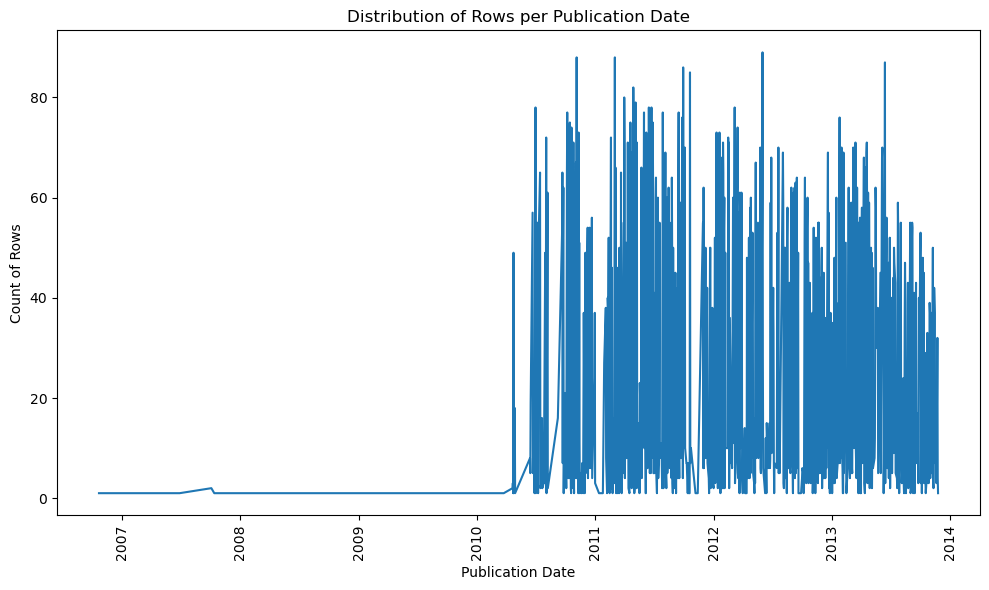

In [10]:
hf_weak_ner_dd = dd.read_parquet("hf://datasets/imvladikon/english_news_weak_ner/articles/train-*.parquet")
hf_weak_ner_df = hf_weak_ner_dd.compute()
hf_weak_ner_df = hf_weak_ner_df[['title', 'text', 'datetime', 'url']].rename(
    columns={'text': 'description', 'datetime':'date'}
)
hf_weak_ner_df['source'] = 'Bloomberg'

print("Initial dataset size : " + str(len(hf_weak_ner_df)))

hf_weak_ner_df_agri = filter_agri(hf_weak_ner_df, True, True)
print("Filtered dataset size : " + str(len(hf_weak_ner_df_agri)))

hf_weak_ner_df_agri = time_analysis(hf_weak_ner_df_agri)

#### All The News Component One

All the News Dataset is probably the most complete dataset we used as it includes 2.7 million news articles from 27 American publications, spanning from 2016 to early 2020. From this dataset, we successfully filtered around 200'000 agriculture-related articles. 

https://huggingface.co/datasets/rjac/all-the-news-2-1-Component-one

Initial dataset size : 2688878
Filtered dataset size : 238692


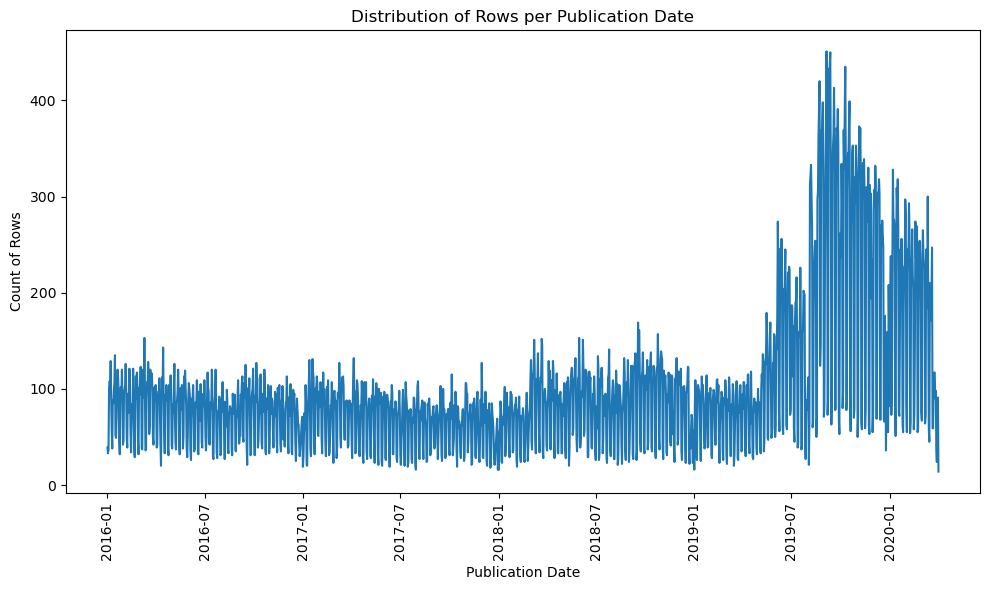

In [11]:
hf_all_comp_dd = dd.read_parquet("hf://datasets/rjac/all-the-news-2-1-Component-one/data/train-*-of-*.parquet")
hf_all_comp_df = hf_all_comp_dd.compute()
hf_all_comp_df = hf_all_comp_df[['title', 'article', 'date', 'url', 'publication']].rename(
    columns={'article': 'description', 'publication':'source'}
)

print("Initial dataset size : " + str(len(hf_all_comp_df)))

hf_all_comp_df_agri = filter_agri(hf_all_comp_df, True, True)
print("Filtered dataset size : " + str(len(hf_all_comp_df_agri)))

hf_all_comp_df_agri = time_analysis(hf_all_comp_df_agri)

#### CS News V2

https://huggingface.co/datasets/myradeng/cs-230-news-v2

Initial dataset size : 257648
Filtered dataset size : 2843


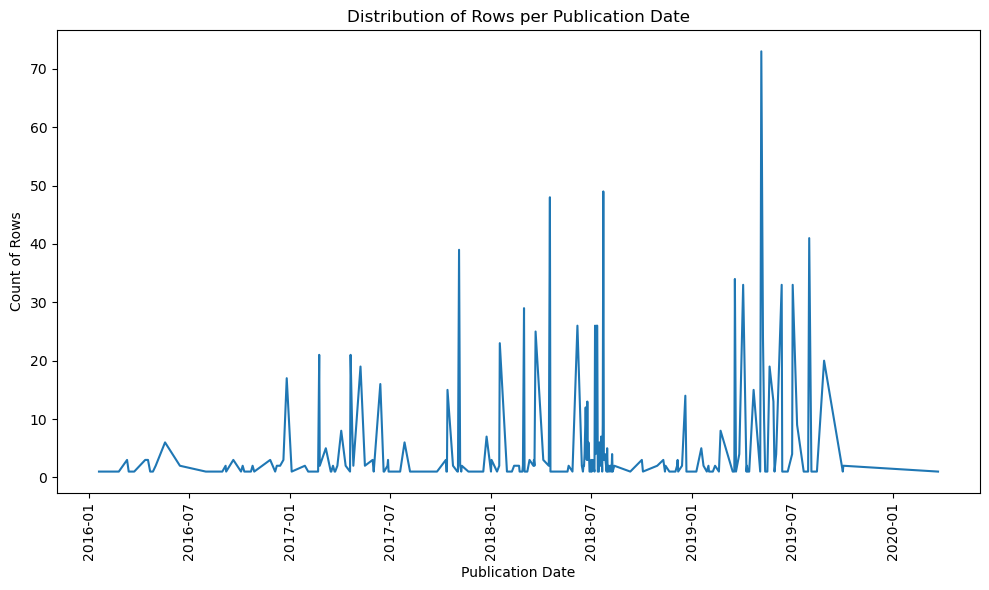

In [12]:
splits = {'train': 'train.csv', 'validation': 'dev.csv', 'test': 'test.csv'}
v2_df = pd.read_csv("hf://datasets/myradeng/cs-230-news-v2/" + splits["train"])

v2_df = v2_df[['title', 'content', 'date', 'url', 'publication']].rename(
    columns={'content': 'description', 'publication':'source'}
)

print("Initial dataset size : " + str(len(v2_df)))

v2_df_agri = filter_agri(v2_df, True, True)
print("Filtered dataset size : " + str(len(v2_df_agri)))

v2_df_agri = time_analysis(v2_df_agri)

#### CS News V3 

https://huggingface.co/datasets/myradeng/cs-230-news-v3

Initial dataset size : 1079136
Filtered dataset size : 11692


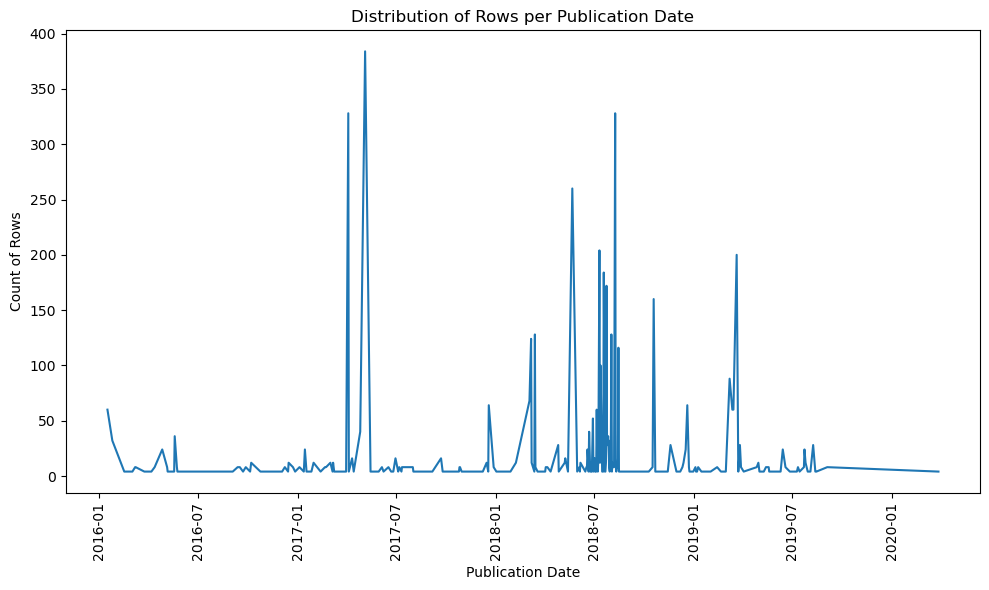

In [13]:
splits = {'train': '**/train[-._ 0-9]*', 'validation': 'dev.csv', 'test': 'test.csv'}
v3_dd = dd.read_csv("hf://datasets/myradeng/cs-230-news-v3/" + splits["train"])
v3_df = v3_dd.compute()

v3_df = v3_df[['title', 'content', 'date', 'url', 'publication']].rename(
    columns={'content': 'description', 'publication':'source'}
)

print("Initial dataset size : " + str(len(v3_df)))

v3_df_agri = filter_agri(v3_df, True, True)
print("Filtered dataset size : " + str(len(v3_df_agri)))

v3_df_agri = time_analysis(v3_df_agri)

#### Frontpage News

Frontpage News is the second most important dataset we used, encompassing around 13 million english news articles from around 90 news outlets and spanning from 2016 to 2020. From this dataset, we successfully filtered 100'000 agriculture-related articles. 

https://huggingface.co/datasets/AndyReas/frontpage-news

Initial dataset size : 13118041
Filtered dataset size : 111639


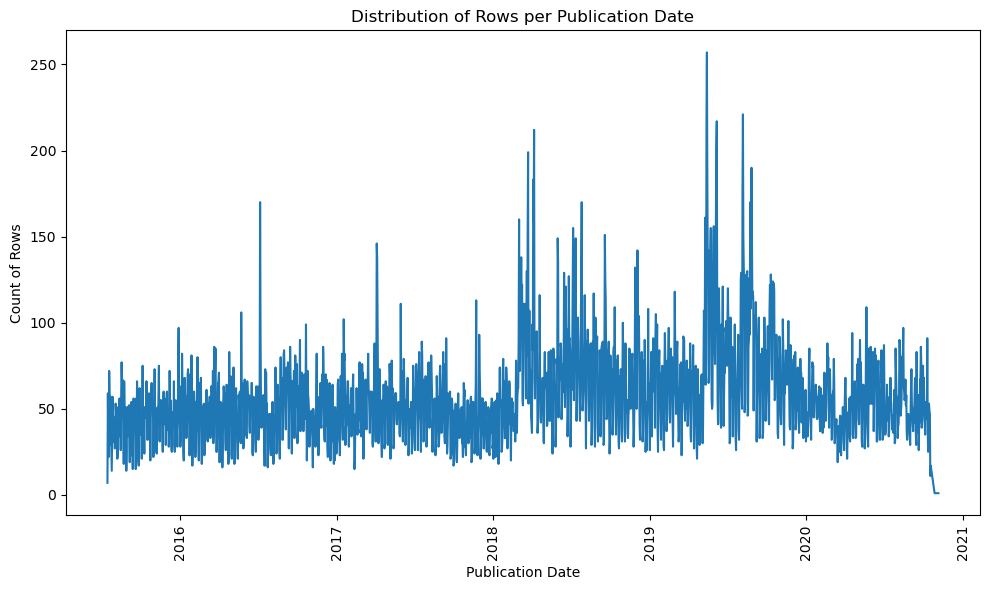

In [14]:
frontpage_dd = dd.read_parquet("hf://datasets/AndyReas/frontpage-news/data/train-*-of-*.parquet")
frontpage_df = frontpage_dd.compute()

frontpage_df = frontpage_df[['title', 'description', 'meta']]
frontpage_df['date_raw'] = frontpage_df['meta'].apply(lambda x: x.get('date') if isinstance(x, dict) else None)
frontpage_df['date'] = pd.to_datetime(frontpage_df['date_raw'], format='%Y%m%d', errors='coerce')

frontpage_df = frontpage_df[['title', 'description', 'date']]

print("Initial dataset size : " + str(len(frontpage_df)))

frontpage_df_agri = filter_agri(frontpage_df, True, True)
print("Filtered dataset size : " + str(len(frontpage_df_agri)))

frontpage_df_agri = time_analysis(frontpage_df_agri)

## Combined Dataframe

We combine all the news datasets we were able to obtain and remove potential duplicates. Furthermore, we chose to conduct our analysis on both the titles and the descriptions, therefore, we merged both in one column "article".

The initial length is 334505.
The final length (without duplicates) is 301279.


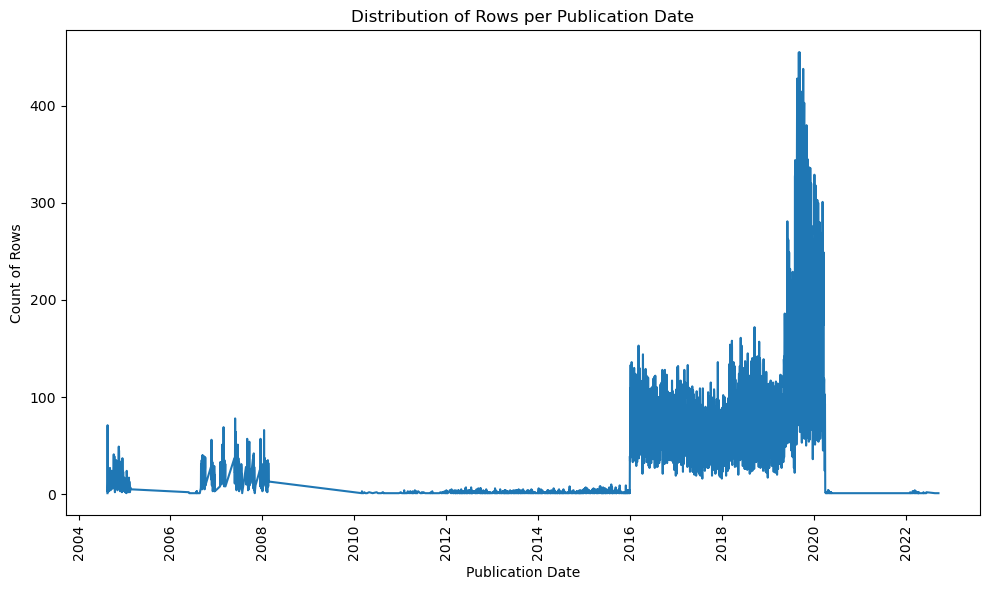

In [16]:
dfs = [ag_agri_df, christo_df, kaggle_df_agri, hf_all_comp_df_agri, hf_bbc_alltime_df_agri, hf_fin_news_df_agri, hf_weak_ner_df_agri, v2_df_agri, v3_df_agri, frontpage_df_agri]
combined_df = pd.concat(dfs, ignore_index=True, sort=False)

combined_df["date"] = pd.to_datetime(combined_df["date"], errors='coerce')
combined_df = combined_df.sort_values(by="date", ascending=True)

# drop duplicates
print(f"The initial length is {len(combined_df)}.")
combined_df = combined_df.drop_duplicates(subset=['title', 'date', 'url'], keep='first')
print(f"The final length (without duplicates) is {len(combined_df)}.")

combined_df['article'] = combined_df['title'].fillna('') + " " + combined_df['description'].fillna('')

combined_df = time_analysis(combined_df)

In [ ]:
joblib.dump(combined_df, "data/merged_data.joblib")

['data/merged_data.joblib']